<a href="https://colab.research.google.com/github/VIBGYOR-TEAM/Soil-Testing-Machine/blob/main/Soil_Type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.0.0
!pip install imutils

     |████████████████████████████████| 86.3MB 90kB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 450kB 39.4MB/s 
     |████████████████████████████████| 3.8MB 35.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=980964702694c7e905914426a14a931aeeaa01b7c6de350fc2d1e80747941a2d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstal

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt

import cv2
from imutils import paths
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:

print("Tensorflow version: ",tf.__version__)

In [ ]:
import zipfile
with zipfile.ZipFile("Soil_Dataset.zip","r") as zip_ref:
    zip_ref.extractall("Dataset")

In [ ]:

train_dir = 'Dataset/Soil_Dataset/Train'
test_dir = 'Dataset/Soil_Dataset/Test'

In [ ]:

image_size = 224

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                            rotation_range=45,
                            zoom_range=0.40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            vertical_flip= True,
                            fill_mode="nearest")

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(150,150),
                                              batch_size=32,
                                              class_mode="categorical")

Found 715 images belonging to 4 classes.


In [ ]:

test_datagen = ImageDataGenerator(rescale = 1./255)

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(150,150),
                                            batch_size=32,
                                            class_mode="categorical")


Found 188 images belonging to 4 classes.


Model: "SoilNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        6560

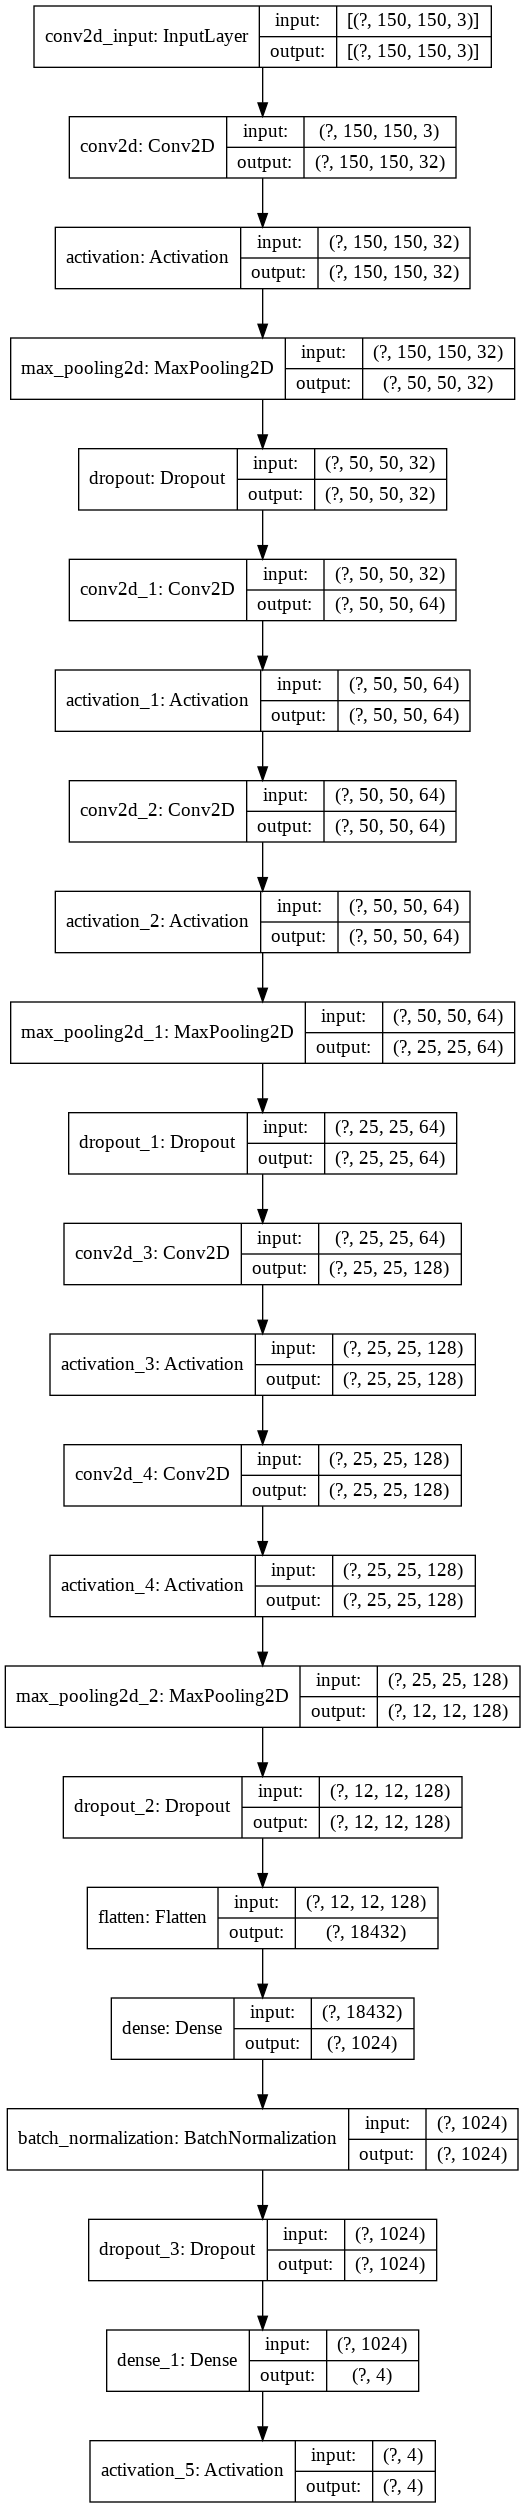

In [ ]:
chanDim = 1
model = Sequential(name="SoilNet")
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(150,150,3)))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(64, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (4, 4), padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(128, (4, 4), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation("softmax"))


model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
reduction_lr = ReduceLROnPlateau(monitor = "val_accuracy",patience = 2 ,verbose = 1, factor = 0.2, min_lr = 0.00001)
model.summary()
plot_model(model,show_shapes=True)


In [ ]:
callback_list = [reduction_lr]

In [ ]:
start = time.time()

history = model.fit_generator(train_data,
                    steps_per_epoch = 30,
                    validation_data = test_data,
                    validation_steps = 30,
                    epochs=20,
                    callbacks = callback_list)
end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/20
30/30 [==============================] - 149s 5s/step - loss: 0.3623 - accuracy: 0.8758 - val_loss: 0.7265 - val_accuracy: 0.8032
Epoch 2/20
30/30 [==============================] - 149s 5s/step - loss: 0.4683 - accuracy: 0.8339 - val_loss: 0.7218 - val_accuracy: 0.7606
Epoch 3/20
29/30 [============================>.] - ETA: 4s - loss: 0.3344 - accuracy: 0.8732
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
30/30 [==============================] - 152s 5s/step - loss: 0.3275 - accuracy: 0.8754 - val_loss: 0.8718 - val_accuracy: 0.7606
Epoch 4/20
30/30 [==============================] - 156s 5s/step - loss: 0.3162 - accuracy: 0.8954 - val_loss: 0.3106 - val_accuracy: 0.9043
Epoch 5/20
30/30 [==============================] - 159s 5s/step - loss: 0.2491 - accuracy: 0.9125 - val_loss: 0.4104 - val_accuracy: 0.8777
Epoch 6/20
29/30 [============================>.] - ETA: 3s - loss: 0.3133 - accuracy: 0.8984
Epoch 00006: ReduceLROnPlateau reduci

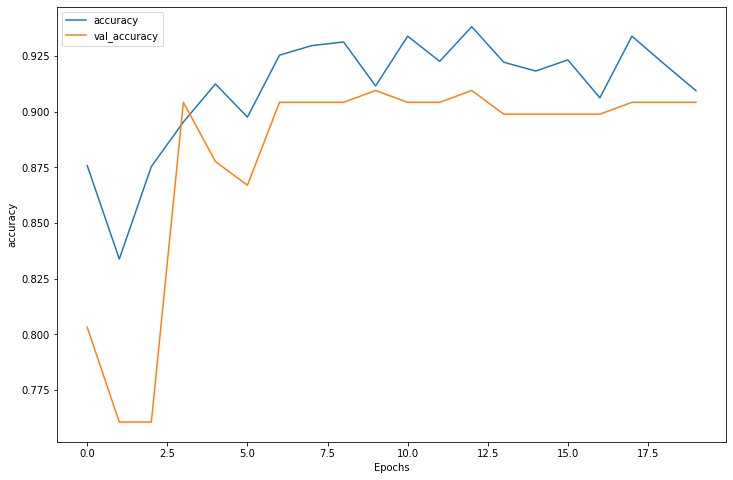

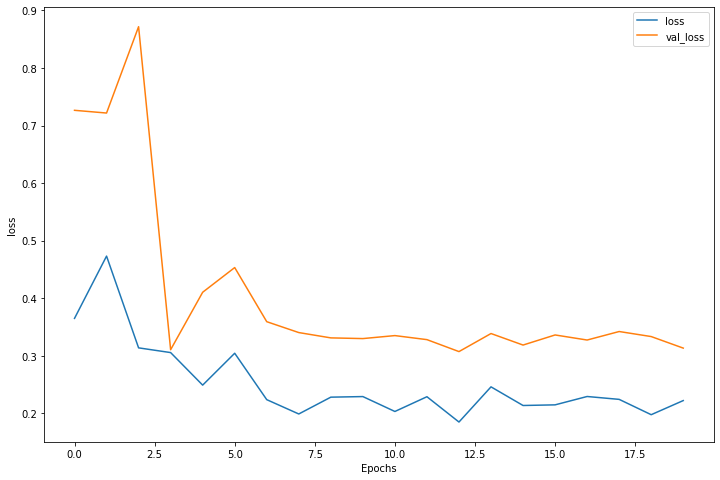

In [ ]:

def plot_graph(history,string):
    plt.figure(figsize=(12,8))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label="val_"+str(string))
    plt.xlabel("Epochs")
    plt.ylabel(str(string))
    plt.legend()
    plt.show()
plot_graph(history,"accuracy")
plot_graph(history,"loss")